## Overview

We would like to get a database with an history of the average temperature per day in the main world cities. We would use the geobases database to get a list of cities and the climate data in the daily GHCN database.
Therefore, we will extract the nearest weather station WITH temperature data to a city in the geobases list.

In [1]:
#Getting the climate data
!wget http://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2016.csv.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#Unzip the 2016 data
!gunzip 2016.csv.gz

'gunzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
#Get the stations data
!wget http://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt -O stations.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [64]:
import pandas as pd

## Load and parsing of stations data

We load the stations data description and extract the information we need: id, coordinates and city name

In [65]:
#List of stations
!cat stations.txt | head -n 10

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [66]:
stationstxt = ""
with open("stations.txt") as input:
    stationstxt = input.read()

In [67]:
#Extract the data from file
stations = stationstxt.split("\n")

#Remove last line
stations = stations[:-1]

stations = list(map(lambda line: [line[0:11],float(line[13:20]),float(line[22:30]),line[41:71]], stations))

In [68]:
len(stations)

106283

In [69]:
stations[:5]

[['ACW00011604', 17.1167, -61.7833, 'ST JOHNS COOLIDGE FLD         '],
 ['ACW00011647', 17.1333, -61.7833, 'ST JOHNS                      '],
 ['AE000041196', 25.333, 55.517, 'SHARJAH INTER. AIRP           '],
 ['AEM00041194', 25.255, 55.364, 'DUBAI INTL                    '],
 ['AEM00041217', 24.433, 54.651, 'ABU DHABI INTL                ']]

## Selection of stations with temperature data

We read the climate data file, select only the lines with temperature data TAVG and extract the list of stations.

In [70]:
!cat 2016.csv | head -n 10

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [71]:
weatherdf = pd.read_csv("2016.csv",header=None)
weatherdf.columns = ["id","date","type","Value1","Value2","Value3","Value4","Value5"]
weatherdf.head()

,id,date,type,Value1,Value2,Value3,Value4,Value5
0,US1MNCV0008,20160101,PRCP,0,T,NaN,N,NaN
1,US1MNCV0008,20160101,SNOW,0,T,NaN,N,NaN
2,US1MNCV0008,20160101,SNWD,127,NaN,NaN,N,NaN
3,CA1AB000023,20160101,PRCP,0,NaN,NaN,N,NaN
4,CA1AB000023,20160101,SNOW,0,NaN,NaN,N,NaN


In [72]:
#Get total number of days
days = len(weatherdf.groupby("date").groups.keys())
days

366

In [73]:
#Check all the types of measures that are done
weatherdf.groupby("type").groups.keys()

dict_keys(['AWDR', 'AWND', 'DAPR', 'DASF', 'DATN', 'DATX', 'DWPR', 'EVAP', 'MDPR', 'MDSF', 'MDTN', 'MDTX', 'MNPN', 'MXPN', 'PGTM', 'PRCP', 'PSUN', 'SN31', 'SN32', 'SN33', 'SN35', 'SN36', 'SN51', 'SN52', 'SN53', 'SN55', 'SN56', 'SNOW', 'SNWD', 'SX31', 'SX32', 'SX33', 'SX35', 'SX36', 'SX51', 'SX52', 'SX53', 'SX55', 'SX56', 'TAVG', 'THIC', 'TMAX', 'TMIN', 'TOBS', 'TSUN', 'WDF2', 'WDF5', 'WDFG', 'WDMV', 'WESD', 'WESF', 'WSF2', 'WSF5', 'WSFG', 'WSFI', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT10', 'WT11', 'WT17', 'WT18'])

In [74]:
#Let's create a list of stations with the TAVG data
stationstavg = weatherdf[weatherdf["type"]=="TAVG"].groupby("id")["date"].count()

In [75]:
len(stationstavg)

7077

Populating the interactive namespace from numpy and matplotlib


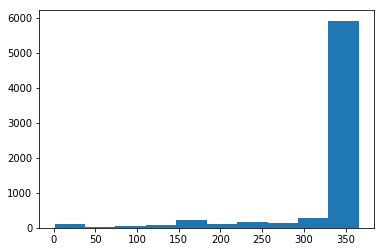

In [76]:
#We visualize the days covered by the station with temperature data
%pylab inline
plt.hist(stationstavg)
plt.show()

In [77]:
stationstavg = stationstavg[stationstavg>45].reset_index()

# Merge of the stations list with the temperature stations to get info on the temperature stations

In [78]:
#We filter the stations and only take the ones with tavg
stationsdf = pd.DataFrame(stations)
stationsdf.columns = ["id","lat","lng","name"]
print(len(stationsdf))
stationsdf = stationsdf.merge(stationstavg,on="id")[["id","lat","lng","name"]]
print(len(stationsdf))
stations = stationsdf.values.tolist()

106283
6955


## Find the nearest city to each weather station (10km radius)

In [79]:
# Let's download the optd_por file
optd_por = pd.read_csv("https://raw.githubusercontent.com/opentraveldata/opentraveldata/master/opentraveldata/optd_por_public.csv",sep="^")

In [80]:
optd_por.columns

Index(['iata_code', 'icao_code', 'faa_code', 'is_geonames', 'geoname_id',
       'envelope_id', 'name', 'asciiname', 'latitude', 'longitude', 'fclass',
       'fcode', 'page_rank', 'date_from', 'date_until', 'comment',
       'country_code', 'cc2', 'country_name', 'continent_name', 'adm1_code',
       'adm1_name_utf', 'adm1_name_ascii', 'adm2_code', 'adm2_name_utf',
       'adm2_name_ascii', 'adm3_code', 'adm4_code', 'population', 'elevation',
       'gtopo30', 'timezone', 'gmt_offset', 'dst_offset', 'raw_offset',
       'moddate', 'city_code_list', 'city_name_list', 'city_detail_list',
       'tvl_por_list', 'state_code', 'location_type', 'wiki_link',
       'alt_name_section', 'wac', 'wac_name', 'ccy_code'],
      dtype='object')

In [81]:
optd_por=optd_por[optd_por["location_type"]=="C"]

In [82]:
from vincenty import vincenty

In [83]:
def getCity(lat,lng):
    o2=optd_por.copy()
    o2=o2[(o2["latitude"]<lat+1)&(o2["latitude"]>lat-1)&(o2["longitude"]>lng-1)&(o2["longitude"]<lng+1)]
    if len(o2)==0:
        return ""
    o2["d"]=o2.apply(lambda row: vincenty((row["latitude"],row["longitude"]),(lat,lng)),1)
    res = o2.sort_values("d").head(1)
    if res["d"].values[0]>10:
        return ""
    else:
        return res['iata_code'].values[0]

In [84]:
from tqdm import tqdm_notebook as tqdm

In [85]:
len(list(stations))

6955

In [86]:
stations = list(map(lambda s: s + [getCity(s[1],s[2])],tqdm(stations)))

A Jupyter Widget

In [87]:
stations[:5]

[['AE000041196', 25.333, 55.517, 'SHARJAH INTER. AIRP           ', ''],
 ['AEM00041194', 25.255, 55.364, 'DUBAI INTL                    ', ''],
 ['AEM00041217', 24.433, 54.651, 'ABU DHABI INTL                ', 'AYM'],
 ['AEM00041218', 24.262, 55.609, 'AL AIN INTL                   ', ''],
 ['AFM00040938', 34.21, 62.228, 'HERAT                         ', '']]

In [88]:
stationsdf = pd.DataFrame(stations)
stationsdf.columns = ["id","lat","lng","name","asciicity"]

In [89]:
#We take only the stations near a city
stationswithcity = stationsdf[stationsdf["asciicity"]!=""]

In [90]:
len(stationsdf)

6955

In [91]:
len(stationswithcity)

1505

In [92]:
citiesdf = stationswithcity.groupby("asciicity").first().reset_index()

In [93]:
#Number of cities with one or several weather stations
len(citiesdf)

1398

In [94]:
#We write the result to a csv
open("citiesweather.csv","w").write(citiesdf.to_csv())

91416

In [95]:
#Example with Madrid
citiesdf[citiesdf["asciicity"].str.contains("MAD")]

,asciicity,id,lat,lng,name
668,MAD,SPE00120287,40.3778,-3.7892,MADRID/CUATROVIENTOS


In [96]:
citiesdf.sample(5)

,asciicity,id,lat,lng,name
160,CAE,USW00013883,33.9486,-81.1186,COLUMBIA
526,KEJ,RSM00029642,55.2700,86.1070,KEMEROVO
333,FNT,USW00014826,42.9667,-83.7494,FLINT BISHOP INTL AP
216,CQM,SPE00120035,38.9892,-3.9194,CIUDAD REAL
1230,XBR,CA006100970,44.6333,-75.7500,BROCKVILLE CLIMATE


# Now we can extract the temperature data for any city by its iata code

In [101]:
citiesdf[citiesdf["asciicity"]=="PAR"]

,asciicity,id,lat,lng,name
834,PAR,FR000007150,48.8231,2.3367,PARIS/LE BOURGET


In [102]:
#First we find the id of the station assigend to Madrid
code = citiesdf[citiesdf["asciicity"]=="MAD"]["id"].values[0]
code

'SPE00120287'

In [103]:
#Now we extract the data from the climate table
datatavg = weatherdf[(weatherdf["id"]==code)&(weatherdf["type"]=="TAVG")].sort_values("date")
datatavg["Value1"]=datatavg["Value1"]/10
datatavg = datatavg.reset_index()
datatavg.sample(5)

,index,id,date,type,Value1,Value2,Value3,Value4,Value5
159,15484787,SPE00120287,20160608,TAVG,28.9,H,NaN,S,NaN
131,12828425,SPE00120287,20160511,TAVG,11.3,H,NaN,S,NaN
138,13494852,SPE00120287,20160518,TAVG,20.7,H,NaN,S,NaN
351,33945096,SPE00120287,20161218,TAVG,8.8,H,NaN,S,NaN
220,21290582,SPE00120287,20160808,TAVG,29.7,H,NaN,S,NaN


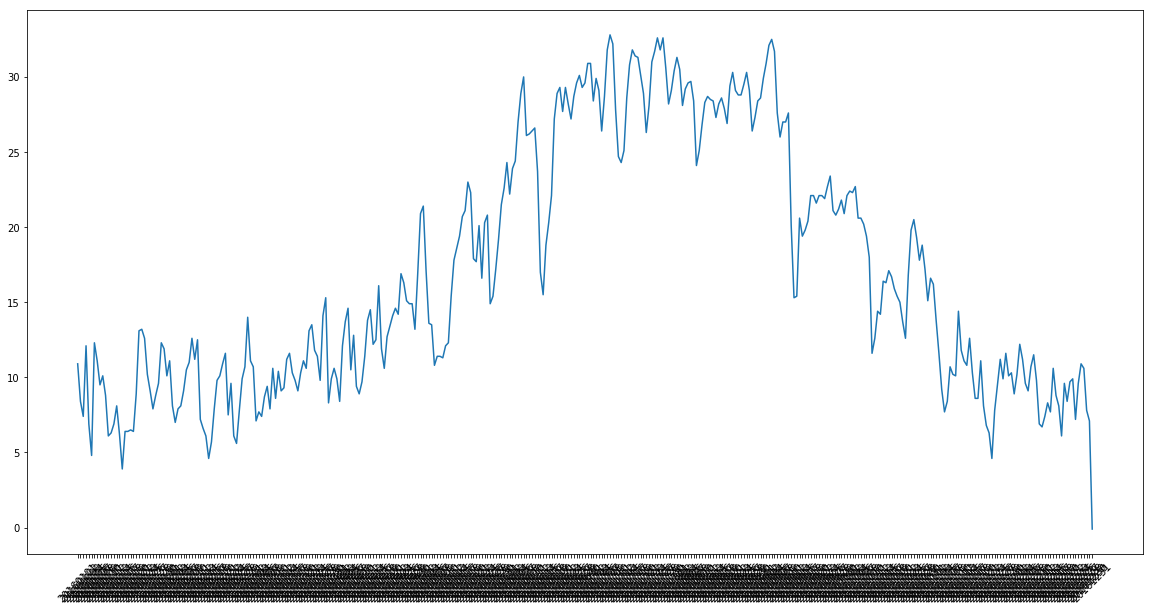

In [104]:
plt.figure(figsize=(20,10))
x = range(len(datatavg))
plt.plot(x,datatavg["Value1"])
plt.xticks(x, datatavg["date"], rotation='45')
plt.show()